<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [2]:
# Открываем и считываем файл, поставим id пользователей за индекс
try:
    df = pd.read_csv('/datasets/Churn.csv', index_col=1)
except:
    df = pd.read_csv('Churn.csv', index_col=1)
df.head()

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,,
15634602,1,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,2,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,3,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,4,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,5,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# переименуем колонки под стать
df = df.rename(columns={'RowNumber' : 'row_number',
                        'Surname' : 'surname', 
                        'CreditScore' : 'credit_score', 
                        'Geography' : 'geography', 
                        'Gender' : 'gender', 
                        'Age' : 'age',
                        'Tenure' : 'tenure', 
                        'Balance' : 'balance',
                        'NumOfProducts' : 'num_of_products',
                        'HasCrCard' : 'has_cr_card',
                        'IsActiveMember' : 'is_active_member',
                        'EstimatedSalary' : 'estimated_salary',
                        'Exited' : 'exited'})

df.index.name = 'customer_id'
df.head()

,row_number,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,,,
15634602,1,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,2,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,3,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,4,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,5,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# рассмотрим пропуски, типы данных и объем испотльзуемой памяти
df.info()
d_memory = df.memory_usage().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            9091 non-null   float64
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [5]:
# посмотрим на плотность распределения данных
df.describe()

,row_number,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# С высоты птичьего полета, NaN проглядывается у новых клиентов, покуда имеют продукты или активность итд
df[df['tenure'].isna()].isna()

,row_number,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,,,
15589475,False,False,False,False,False,False,True,False,False,False,False,False,False
15766205,False,False,False,False,False,False,True,False,False,False,False,False,False
15768193,False,False,False,False,False,False,True,False,False,False,False,False,False
15702298,False,False,False,False,False,False,True,False,False,False,False,False,False
15651280,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15703923,False,False,False,False,False,False,True,False,False,False,False,False,False
15707861,False,False,False,False,False,False,True,False,False,False,False,False,False
15642785,False,False,False,False,False,False,True,False,False,False,False,False,False


In [7]:
# заменим на 0
df['tenure'] = df['tenure'].fillna(0)

In [8]:
# уменьшим объем используемой памяти для обучения
df = df.astype({'row_number':'uint32', 
                'surname':'<U35', 
                'credit_score':'uint32', 
                'geography':'<U60', 
                'age' : 'uint8',
                'tenure' : 'uint8',
                'balance' : 'uint32',
                'num_of_products' : 'uint8',
                'has_cr_card' : 'uint8',
                'is_active_member' : 'uint8',
                'estimated_salary' : 'uint32',
                'exited' : 'uint8'}, errors='ignore')

# заменим Male и Female на 1 и 0
df['gender'] = df['gender'].apply(lambda x : 1 if x == 'Male' else 0).astype('uint8')

new_d_memory = df.memory_usage().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   row_number        10000 non-null  uint32
 1   surname           10000 non-null  object
 2   credit_score      10000 non-null  uint32
 3   geography         10000 non-null  object
 4   gender            10000 non-null  uint8 
 5   age               10000 non-null  uint8 
 6   tenure            10000 non-null  uint8 
 7   balance           10000 non-null  uint32
 8   num_of_products   10000 non-null  uint8 
 9   has_cr_card       10000 non-null  uint8 
 10  is_active_member  10000 non-null  uint8 
 11  estimated_salary  10000 non-null  uint32
 12  exited            10000 non-null  uint8 
dtypes: object(2), uint32(4), uint8(7)
memory usage: 459.0+ KB


In [9]:
print(f'Сократили объем используемой памяти на {round(new_d_memory / d_memory  * 100,1)}%')

Сократили объем используемой памяти на 42.0%


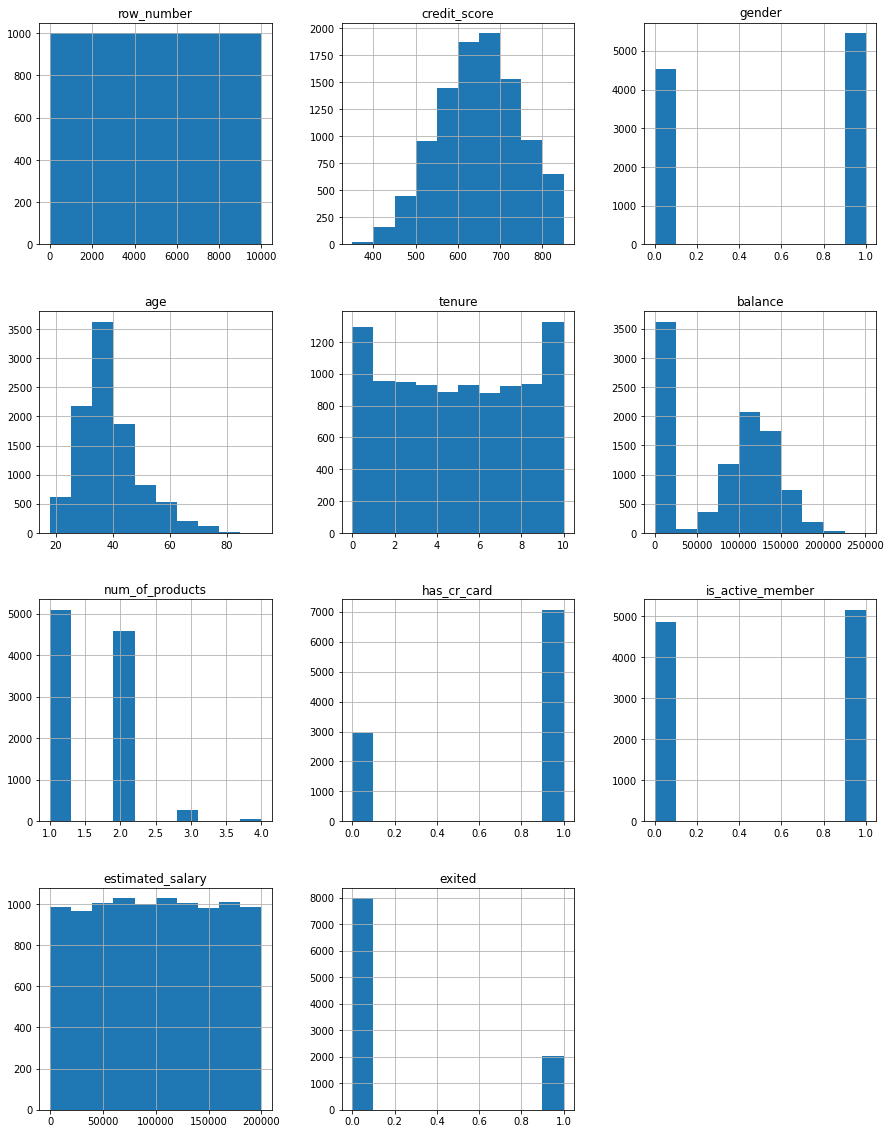

In [10]:
# построим графики, чтобы посмотреть на распределение
df.hist(figsize=(15,20));

**Рассмотрим признаки по очереди**

In [11]:
# Заведём множества для категоризации признаков
drop_features = set()
categorical_features = set()
numeric_features = set()

**row_number**

In [12]:
col = 'row_number'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [    1     2     3 ...  9998  9999 10000]


In [13]:
# Вывод: эту колонку можно выбросить из обучения, это просто поядковые номера
drop_features.add(col)

**surname**

In [14]:
col = 'surname'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']


In [15]:
# Вывод: эту колонку можно выбросить из обучения, это слишком уникальные значения
drop_features.add(col)

**credit_score**

In [16]:
col = 'credit_score'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 709 705

In [17]:
# Вывод - признак численный
numeric_features.add(col)

**geography**

In [18]:
col = 'geography'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['France' 'Spain' 'Germany']


In [19]:
# Вывод: эту колонку можно выбросить из обучения. Да
drop_features.add(col)

**gender**

In [20]:
col = 'gender'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [0 1]


In [21]:
# Вывод - это категориальный признак
categorical_features.add(col)

**tenure**

In [22]:
col = 'tenure'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [ 2  1  8  7  4  6  3 10  5  9  0]


In [23]:
# Вывод - признак численный
numeric_features.add(col)

**balance**

In [24]:
col = 'balance'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [     0  83807 159660 ... 155060  57369 130142]


In [25]:
# Вывод - признак численный
numeric_features.add(col)

**num_of_products**

In [26]:
col = 'num_of_products'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [1 3 2 4]


In [27]:
# Вывод - признак численный
numeric_features.add(col)

**has_cr_card**

In [28]:
col = 'has_cr_card'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [1 0]


In [29]:
# Вывод - это категориальный признак
categorical_features.add(col)

**is_active_member**

In [30]:
col = 'is_active_member'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [1 0]


In [31]:
# Вывод - это категориальный признак
categorical_features.add(col)

**estimated_salary**

In [32]:
col = 'estimated_salary'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [101348 112542 113931 ...  42085  92888  38190]


In [33]:
# Вывод - признак численный
numeric_features.add(col)

**exited**

In [34]:
col = 'exited'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [1 0]


In [35]:
# Вывод - это категориальный признак
categorical_features.add(col)

In [36]:
# Удалим лишние признаки
df = df.drop(columns=drop_features)

In [37]:
# Выделим признаки и целевой аргумент
X = df.loc[:,:'estimated_salary']
y = df['exited']

In [38]:
# Стандартизуем количественные признаки
# scaler = StandardScaler()
# df[list(numeric_features)] = scaler.fit_transform(df[numeric_features])
# df[list(numeric_features)] = df[list(numeric_features)].astype('float32') 

**Посмотрим, что получилось**

In [39]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   credit_score      10000 non-null  uint32
 1   gender            10000 non-null  uint8 
 2   age               10000 non-null  uint8 
 3   tenure            10000 non-null  uint8 
 4   balance           10000 non-null  uint32
 5   num_of_products   10000 non-null  uint8 
 6   has_cr_card       10000 non-null  uint8 
 7   is_active_member  10000 non-null  uint8 
 8   estimated_salary  10000 non-null  uint32
 9   exited            10000 non-null  uint8 
dtypes: uint32(3), uint8(7)
memory usage: 263.7 KB


,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,
15634602,619,0,42,2,0,1,1,1,101348,1
15647311,608,0,41,1,83807,1,0,1,112542,0
15619304,502,0,42,8,159660,3,1,0,113931,1
15701354,699,0,39,1,0,2,0,0,93826,0
15737888,850,0,43,2,125510,1,1,1,79084,0


**Итог:
<br>1) Данные выглядят прилично, только в одной фиче присутсвовали пропуски, их достаточно много, для данного набора, поэтому просто удалить нельзя, поэтому заменили на 0
<br>2) Так же по мере причесывания данных переименовали колонки и уменьшили объем используемой памяти
<br>3) Колонки с порядковым номером, фамилией и страной(дабы не обвинили в рассизме) удалили, они не несут смысловой нагрузки
<br>4) Выделили целевой признак и стандартизовали количественные
<br>5) На построенных данных можно было заметить, что классы не сбалансированны (последний график сетки)
<br>Получили симпатичный датафрейм**

## Исследование задачи

**Для начала нужно получить выборки: обучающая, валидационная, тестовая**

In [40]:
# Для разбиения на три выборки сначала выделим обучающую выборку, в размере 60%, а потом по 20% на валидационную и тестовую
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

In [41]:
# Стандартизуем количественные признаки
numeric_features = list(numeric_features)
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features]);
X_val[numeric_features] = scaler.transform(X_val[numeric_features]);
X_test[numeric_features] = scaler.transform(X_test[numeric_features]);

In [42]:
print(f"Размер выборки train: X:{X_train.shape}, y:{y_train.shape}")
print(f"Размер выборки validation: X:{X_val.shape}, y:{y_val.shape}")
print(f"Размер выборки test: X:{X_test.shape}, y:{y_test.shape}")

Размер выборки train: X:(6000, 9), y:(6000,)
Размер выборки validation: X:(2000, 9), y:(2000,)
Размер выборки test: X:(2000, 9), y:(2000,)


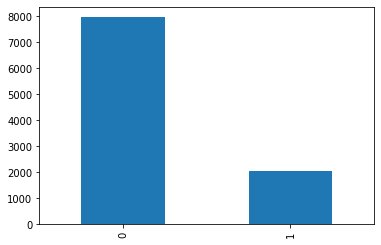

In [43]:
# Еще раз посмотрим и убедимся в несбалансированности классов
y.value_counts().plot(kind='bar');

**Попробуем обучить модели для несбалансированных выборок
<br>Возьмем такие модели как: 1. DecisionTreeClassifier 2. RandomForestClassifier 3. LogisticRegression
<br>Которые мне предложили подизучить в прошлом проекте**

**Поищем лучшие гиперпараметры для случайного леса и дерева решений**

In [44]:
# Начнем с DecisionTreeClassifier
parametrs_dt = {'max_depth': range(1,6)}
model_dt = DecisionTreeClassifier(random_state=12345, 
                                  class_weight = 'balanced')
grid_dt = GridSearchCV(model_dt, parametrs_dt, scoring='f1')
grid_dt.fit(X_train, y_train)
grid_dt.best_params_

{'max_depth': 5}

In [45]:
#  RandomForestClassifier
parametrs_rf = {'n_estimators': range(1,51),
              'max_depth': range(1,6)}
model_rf = RandomForestClassifier(random_state=12345, 
                                  class_weight = 'balanced')
grid_rf = GridSearchCV(model_rf, parametrs_rf,scoring='f1')
grid_rf.fit(X_train, y_train)
grid_rf.best_params_

{'max_depth': 5, 'n_estimators': 28}

**Обучим модели**

In [46]:
# Обучим модель DecisionTreeClassifier на обучающей выборке и посмотрим на f1 на валидациооной 
model_dt = DecisionTreeClassifier(max_depth=5, 
                                  random_state=12345,
                                  class_weight = 'balanced')
model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_val)
model_score_f1 = f1_score(y_val, pred_dt)
model_score_roc = roc_auc_score(y_val, model_dt.predict_proba(X_val)[:,1])
print(f"Метрики f1 = {model_score_f1}, roc_auc = {model_score_roc}")

Метрики f1 = 0.5894962486602359, roc_auc = 0.8197447056902112


In [47]:
# Обучим модель RandomForestClassifier на обучающей выборке и посмотрим на f1 на валидациооной 
model_rf = RandomForestClassifier(max_depth = 9,
                                  n_estimators = 41,
                                  random_state = 12345,
                                  class_weight = 'balanced')
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
model_score_f1 = f1_score(y_val, pred_rf)
model_score_roc = roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,1])
print(f"Метрики f1 = {model_score_f1}, roc_auc = {model_score_roc}")

Метрики f1 = 0.592255125284738, roc_auc = 0.8451418167300794


In [48]:
# Обучим модель LogisticRegression на обучающей выборке и посмотрим на f1 на валидациооной 
model_lr = LogisticRegression(random_state = 12345,
                              class_weight = 'balanced')
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_val)
model_score_f1 = f1_score(y_val, pred_lr)
model_score_roc = roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,1])
print(f"Метрики f1 = {model_score_f1}, roc_auc = {model_score_roc}")

Метрики f1 = 0.48264182895850966, roc_auc = 0.756774780878181


**Рассмотрев все результаты f1 метрик на несбалансированной выборке, видим, что луший показатель у дерева решений
<br>Но нам предстоит еще побороть дисбаланс сил, ниже представлены матрицы ошибок**

In [49]:
# матрица ошибок для дерева решений
confusion_matrix(y_val, pred_dt, normalize='true')

array([[0.8482933 , 0.1517067 ],
       [0.34210526, 0.65789474]])

In [50]:
# матрица ошибок для решающего дерева
confusion_matrix(y_val, pred_rf, normalize='true')

array([[0.87357775, 0.12642225],
       [0.37799043, 0.62200957]])

In [51]:
# матрица ошибок для логистической регрессии
confusion_matrix(y_val, pred_lr, normalize='true')

array([[0.69785082, 0.30214918],
       [0.31818182, 0.68181818]])

**Гляля на матрицы видно сильный дисбаланс классов**

## Борьба с дисбалансом

**Увеличение выборки**

In [52]:
def upsample(features,target,repeat):
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=12345)
    
    return upsampling_features,upsampling_target

features_upsampled, target_upsampled = upsample(X_train, y_train, 4)

In [53]:
# Обучим модель LogisticRegression на увеличенной обучающей выборке и посмотрим на f1 на валидациооной 
model_lr = LogisticRegression(random_state=12345, 
                              solver='liblinear', 
                              class_weight = 'balanced')
model_lr.fit(features_upsampled, target_upsampled)
predicted_valid_lr = model_lr.predict(X_val)
model_score_f1_lr =  f1_score(y_val, predicted_valid_lr)
model_score_roc_lr =  roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,1])  
print(f"Метрики f1 = {model_score_f1_lr}, roc_auc = {model_score_roc_lr}")

Метрики f1 = 0.4839255499153976, roc_auc = 0.7564269684670243


In [54]:
# Обучим модель RandomForestClassifier на увеличенной обучающей выборке и посмотрим на f1 на валидациооной 
model_rf = RandomForestClassifier(max_depth = 9,
                                  n_estimators = 41,
                                  random_state = 12345,
                                  class_weight = 'balanced')
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid_rf = model_rf.predict(X_val)
model_score_f1_rf =  f1_score(y_val, predicted_valid_rf)
model_score_roc_rf =  roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,1])                        
print(f"Метрики f1 = {model_score_f1_rf}, roc_auc = {model_score_roc_rf}")

Метрики f1 = 0.5904365904365904, roc_auc = 0.8422912671864698


In [55]:
# Обучим модель DecisionTreeClassifier на увеличенной обучающей выборке и посмотрим на f1 на валидациооной 
model_dt = DecisionTreeClassifier(max_depth = 5,
                                  random_state = 12345, 
                                  class_weight = 'balanced')
model_dt.fit(features_upsampled, target_upsampled)
predicted_valid_dt = model_dt.predict(X_val)
model_score_f1_dt =  f1_score(y_val, predicted_valid_dt)
model_score_roc_dt =  roc_auc_score(y_val, model_dt.predict_proba(X_val)[:,1])                        
print(f"Метрики f1 = {model_score_f1_dt}, roc_auc = {model_score_roc_dt}")

Метрики f1 = 0.5894962486602359, roc_auc = 0.8197447056902112


**Уменьшение выборки**

In [56]:
def downsample(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=fraction,random_state=12345)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=fraction,random_state=12345)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=12345)
    return downsampling_features,downsampling_target

features_downsample, target_downsample = downsample(X_train, y_train, 0.25)

In [57]:
# Обучим модель LogisticRegression на уменьшенной обучающей выборке и посмотрим на f1 на валидациооной 
model_lr = LogisticRegression(random_state=12345, 
                              solver='liblinear', 
                              class_weight = 'balanced')
model_lr.fit(features_downsample, target_downsample)
predicted_valid_lr = model_lr.predict(X_val)
model_score_f1_lr =  f1_score(y_val, predicted_valid_lr)
model_score_roc_lr =  roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,1])                        
print(f"Метрики f1 = {model_score_f1_lr}, roc_auc = {model_score_roc_lr}")

Метрики f1 = 0.48067226890756304, roc_auc = 0.755769149341576


In [58]:
# Обучим модель RandomForestClassifier на уменьшенной обучающей выборке и посмотрим на f1 на валидациооной 
model_rf = RandomForestClassifier(max_depth = 9,
                                  n_estimators = 41,
                                  random_state = 12345, 
                                  class_weight = 'balanced')
model_rf.fit(features_downsample, target_downsample)
predicted_valid_rf = model_rf.predict(X_val)
model_score_f1_rf =  f1_score(y_val, predicted_valid_rf)
model_score_roc_rf =  roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,1])                        
print(f"Метрики f1 = {model_score_f1_rf}, roc_auc = {model_score_roc_rf}")

Метрики f1 = 0.5826330532212884, roc_auc = 0.8459644686938586


In [59]:
# Обучим модель DecisionTreeClassifier на уменьшенной обучающей выборке и посмотрим на f1 на валидациооной 
model_dt = DecisionTreeClassifier(max_depth = 5,
                                  random_state = 12345, 
                                  class_weight = 'balanced')
model_dt.fit(features_downsample, target_downsample)
predicted_valid_dt = model_dt.predict(X_val)
model_score_f1_dt =  f1_score(y_val, predicted_valid_dt)
model_score_roc_dt =  roc_auc_score(y_val, model_dt.predict_proba(X_val)[:,1])                        
print(f"Метрики f1 = {model_score_f1_dt}, roc_auc = {model_score_roc_dt}")

Метрики f1 = 0.5504761904761905, roc_auc = 0.7998944464943534


**Как видим, уменьшение выборля для баланса класса, позволило нам улучшить модель и получить, f1 > 0.59
<br>Наилучший результат показывают дерево решений и случайный лес**

## Тестирование модели

**Посмотрим, что прокажет на тестовой выборке**

In [60]:
# Обучим модель DecisionTreeClassifier на уменьшенной обучающей выборке и посмотрим на f1 на тестовой 
model_rf = RandomForestClassifier(max_depth = 5,
                                  n_estimators = 49,
                                  random_state = 12345, 
                                  class_weight = 'balanced')
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid_rf = model_rf.predict(X_test)
model_score_f1_rf =  f1_score(y_test, predicted_valid_rf)
model_score_roc_rf =  roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1])                        
print(f"Метрики f1 = {model_score_f1_rf}, roc_auc = {model_score_roc_rf}")

Метрики f1 = 0.5931558935361217, roc_auc = 0.8411008723209374


**Как видим, точность нашей модели превышает наших ожиданий**

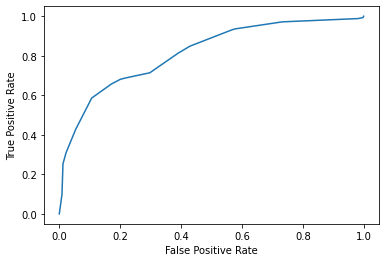

In [61]:
# Посмотрим на ROC кривую
probabilities_test = model_dt.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test) 

plt.figure()
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [62]:
f_imp = model_dt.feature_importances_
f_imp

array([1.13800451e-02, 1.59102789e-02, 5.34101014e-01, 4.44578906e-15,
       3.00190751e-02, 2.98890608e-01, 0.00000000e+00, 9.69063512e-02,
       1.27926273e-02])

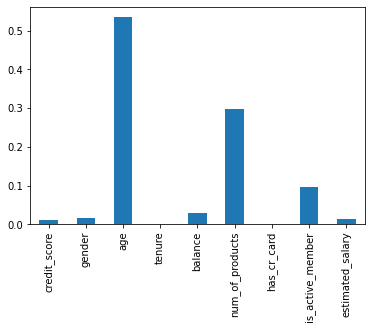

In [63]:
pd.Series(f_imp, index=X.columns).plot(x=X.columns, kind='bar');

**ROC кривая показывает, хороший результат обучения**

**Выводы:
<br>1) Данные, хоть на первый взгляд и хороши, но стоило немного их пречесать, переименовать признаки, изменить типы данных, удалить ненужные, а также стандартизовать колечественные признаки
<br>2) Данные были разбиты 60/20/20 на обучающую, валидационную и тестовую выборку
<br>2) Была определена сильная несбалансированность классов, которую мы исправляли уменьшением, а так же увеличением выборки. Уменьшение выборки, дало нам лучший результат для далнейшего обучения
<br>3) Для трех выбранных моделей были подобранны автоматически лучшие гиперпараметры и уменьшив размер выборки, протестированна лучшая модель, ей оказалась RandomForestClassifier, с максимальной глубиной 5, а метрика f1 оказалась чуть больше 0.59**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [X]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*